## Library

In [1]:
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.lines as mlines

# Prep

## Connection

In [2]:
con = SnowflakeTools(
    role="INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD",
    warehouse="INSIGHT_ANALYST_WH",
    database="BDWPRD_DE",
    schema="IA_MERCH_DE"
)

## Item list

In [3]:
# Load both AU and NZ sheets from the Excel file
item_list = pd.read_excel("Item list.xlsx", sheet_name=None)

# Replace sheet names if needed
au_items = item_list['AU']
nz_items = item_list['NZ']

# Standardise column names (optional but helpful)
au_items.columns = au_items.columns.str.strip().str.lower()
nz_items.columns = nz_items.columns.str.strip().str.lower()

# Ensure item_number is string with leading zeroes
au_items['item_number'] = au_items['item_number'].astype(str).str.zfill(7)
nz_items['item_number'] = nz_items['item_number'].astype(str).str.zfill(7)

In [4]:
# Read product hierarchy
product_hierarchy = con.read_sql_file_into_pandas(
    file="sql/item-hierarchy.sql"
)

snowflake_tools - 2025-06-12 11:30:50.234615+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-12 11:30:55.901002+10:00 - Saved token with '2025-06-12 15:30:55+10:00' expiry...


In [5]:
# Clean column names
product_hierarchy.columns = (
    product_hierarchy.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Ensure item_number is string with 7-digit padding
product_hierarchy['item_number'] = product_hierarchy['item_number'].astype(str).str.zfill(7)

In [6]:
# Merge enriched hierarchy into AU and NZ item lists
au_items_enriched = au_items.merge(product_hierarchy, on='item_number', how='left')
nz_items_enriched = nz_items.merge(product_hierarchy, on='item_number', how='left')


In [7]:
# Function to print unique values for each hierarchy column
def show_unique_hierarchy(df, label):
    print(f"\n🔹 {label}: Unique item_category_name")
    print(df['item_category_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_department_name")
    print(df['item_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_department_name")
    print(df['item_sub_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_class_name")
    print(df['item_class_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_class_name")
    print(df['item_sub_class_name'].dropna().unique())

# Show for both AU and NZ
show_unique_hierarchy(au_items_enriched, "AU ITEMS")
show_unique_hierarchy(nz_items_enriched, "NZ ITEMS")



🔹 AU ITEMS: Unique item_category_name
['200 TIMBER']

🔹 AU ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 AU ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 AU ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 AU ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS BULK STACK' '600 PANELS'
 '600 DRESSED PINE PNL BULK STCK']

🔹 NZ ITEMS: Unique item_category_name
['200 TIMBER']

🔹 NZ ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 NZ ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 NZ ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 NZ ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS' '600 PANELS BULK STACK'
 '600 DRESSED PINE PNL BULK STCK']


# Class-based Performance

In [8]:
# Define time parameters and loyalty filter
start_date = "'2024-07-31'"
end_date = "'2025-06-11'"
start_rrp_date = "2025-01-27"

start_date_LY = "'2023-07-31'"
end_date_LY = "'2024-06-11'"
start_rrp_date_LY = "2024-01-27"

params = {
    'AU': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
        'loyalty_filter': "AND stl.dw_loyalty_flybuys_account_id != MD5_BINARY(-1)"
    },
    'NZ': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
        'loyalty_filter': ""  # No loyalty filter for NZ
    }
}


In [9]:
# Define reusable preparation function
def prepare_df(df, enriched_items, cutoff_date, year_label, country_label):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df['item_number'] = df['item_number'].astype(str).str.zfill(7)
    df['week_start'] = pd.to_datetime(df['week_start'])
    df['rrp_increase'] = df['item_number'].isin(enriched_items['item_number']).map({True: 'Yes', False: 'No'})
    df['period'] = df['week_start'].apply(lambda x: 'Pre' if x < pd.to_datetime(cutoff_date) else 'Post')
    df['year_label'] = year_label
    df['country'] = country_label
    return df

In [10]:
df_all_list = []

for country, cfg in params.items():
    # Read This Year
    df_ty = con.read_sql_file_into_pandas(
        file="sql/class-transactions.sql",
        formatting={
            'start_date': cfg['start_date'],
            'end_date': cfg['end_date'],
            'country': f"'{country}'",
            'loyalty_filter': cfg['loyalty_filter']
        }
    )

    # Read Last Year
    df_ly = con.read_sql_file_into_pandas(
        file="sql/class-transactions.sql",
        formatting={
            'start_date': cfg['start_date_LY'],
            'end_date': cfg['end_date_LY'],
            'country': f"'{country}'",
            'loyalty_filter': cfg['loyalty_filter']
        }
    )

    # Clean and tag
    df_ty = prepare_df(df_ty, au_items_enriched, cfg['start_rrp_date'], 'This Year', country)
    df_ly = prepare_df(df_ly, au_items_enriched, cfg['start_rrp_date_LY'], 'Last Year', country)

    # Add to list
    df_all_list.extend([df_ty, df_ly])

# ---- Combine all ----
df_all = pd.concat(df_all_list, ignore_index=True)

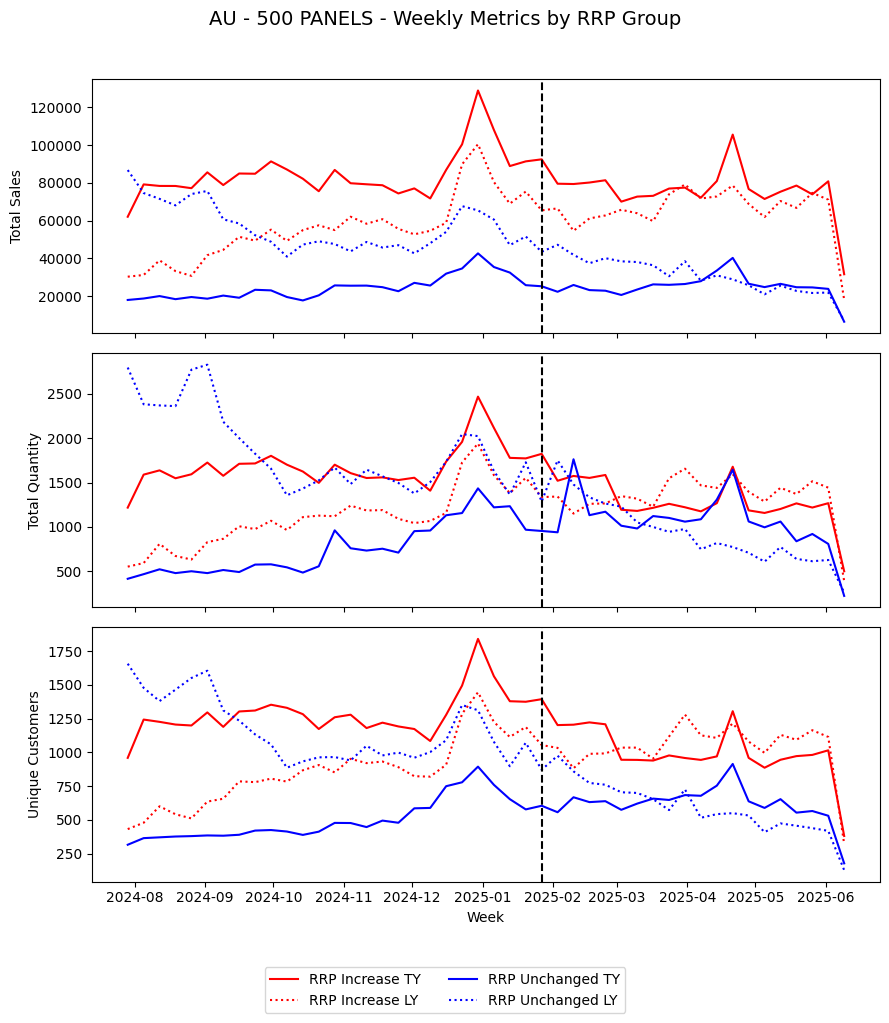

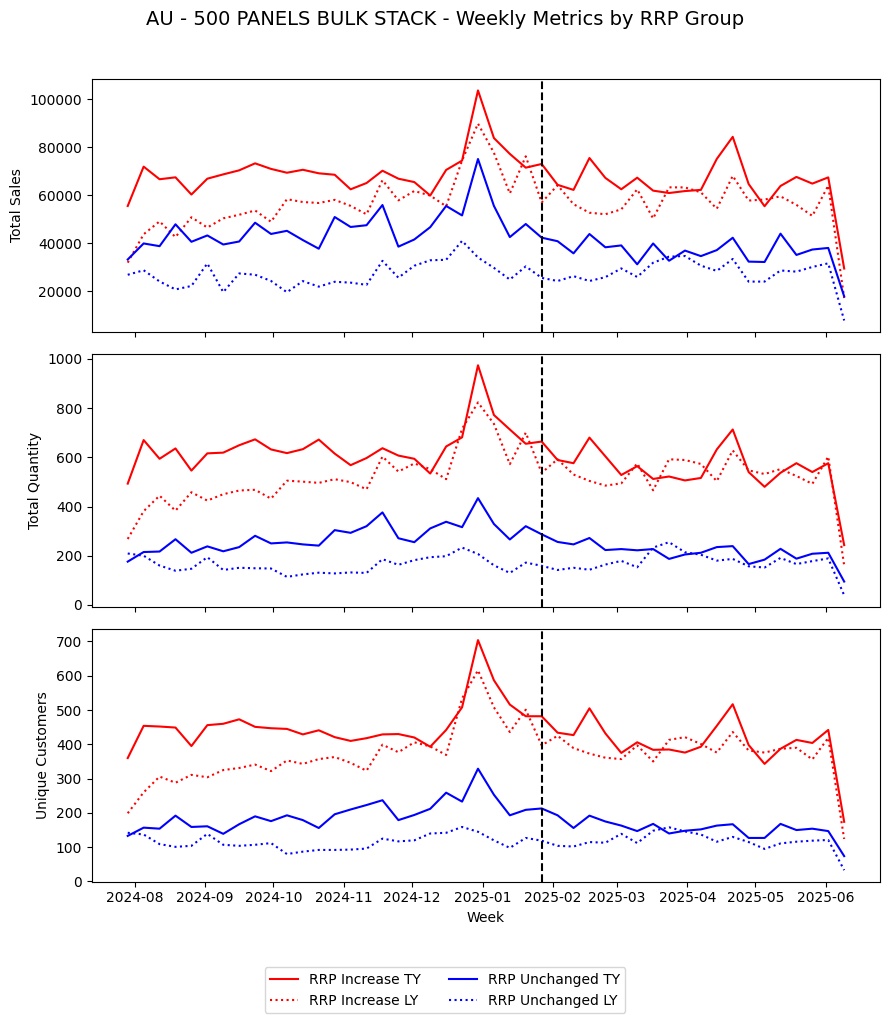

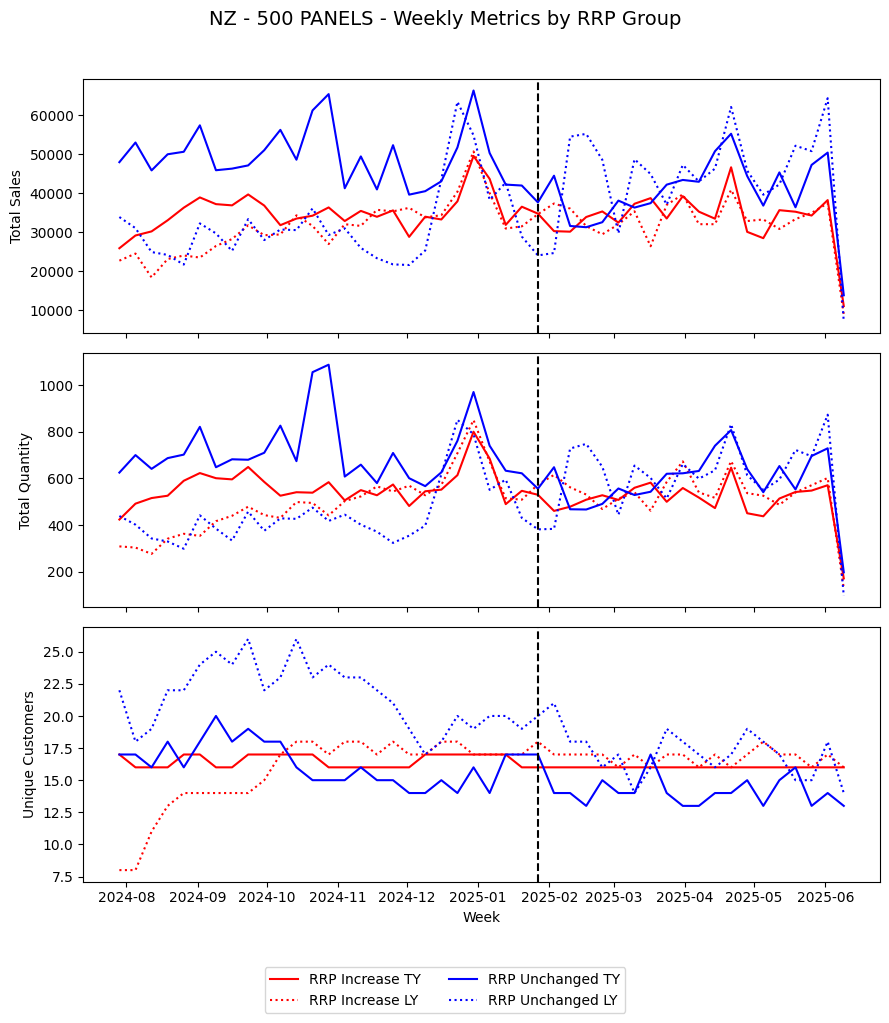

,country,item_class_name,rrp_increase,period,year_label,total_sales,total_quantity,unique_customers,avg_sales_per_week,avg_quantity_per_week,avg_customers_per_week
0,AU,500 PANELS,Yes,Pre,This Year,2196548.05,43667.0,33390,84482.62,1679.50,1284.23
1,AU,500 PANELS,Yes,Pre,Last Year,1440661.46,28478.0,22130,55410.06,1095.31,851.15
2,AU,500 PANELS,Yes,Post,This Year,1529455.46,26038.0,20351,76472.77,1301.90,1017.55
3,AU,500 PANELS,Yes,Post,Last Year,1306912.51,26785.0,20715,65345.63,1339.25,1035.75
4,AU,500 PANELS,No,Pre,This Year,636044.23,19575.0,12970,24463.24,752.88,498.85
5,AU,500 PANELS,No,Pre,Last Year,1477098.53,48755.0,30346,56811.48,1875.19,1167.15
6,AU,500 PANELS,No,Post,This Year,501119.87,21176.0,12325,25055.99,1058.80,616.25
7,AU,500 PANELS,No,Post,Last Year,625154.80,18874.0,12049,31257.74,943.70,602.45
8,AU,500 PANELS BULK STACK,Yes,Pre,This Year,1820890.32,16641.0,11872,70034.24,640.04,456.62
9,AU,500 PANELS BULK STACK,Yes,Pre,Last Year,1488325.78,13485.0,9612,57243.30,518.65,369.69


In [11]:
# Define plot settings
plot_colors = {'Yes': 'red', 'No': 'blue'}
line_styles = {'This Year': 'solid', 'Last Year': 'dotted'}

# Storage
formatted_class_summaries = []

# Plot and summarise per class and country
for (country, class_name), df_class in df_all.groupby(['country', 'item_class_name']):
    # Weekly total aggregation for plotting
    df_weekly = df_class.groupby(
        ['week_start', 'rrp_increase', 'year_label']
    )[['total_sales', 'total_quantity', 'unique_customers']].sum().reset_index()

    # Total sums and weekly counts for average metrics
    df_summary_raw = df_class.groupby(
        ['country', 'item_class_name', 'rrp_increase', 'period', 'year_label']
    ).agg(
        total_sales=('total_sales', 'sum'),
        total_quantity=('total_quantity', 'sum'),
        unique_customers=('unique_customers', 'sum'),
        weeks=('week_start', pd.Series.nunique)
    ).reset_index()

    # Compute average weekly metrics
    df_summary_raw['avg_sales_per_week'] = (df_summary_raw['total_sales'] / df_summary_raw['weeks']).round(2)
    df_summary_raw['avg_quantity_per_week'] = (df_summary_raw['total_quantity'] / df_summary_raw['weeks']).round(2)
    df_summary_raw['avg_customers_per_week'] = (df_summary_raw['unique_customers'] / df_summary_raw['weeks']).round(2)

    # Round other columns
    df_summary_raw[['total_sales', 'total_quantity', 'unique_customers']] = df_summary_raw[
        ['total_sales', 'total_quantity', 'unique_customers']
    ].round(2)

    # Drop week count after computing averages
    df_summary = df_summary_raw.drop(columns='weeks')

    # Sort table
    df_summary['rrp_order'] = df_summary['rrp_increase'].map({'Yes': 0, 'No': 1})
    df_summary['period_order'] = df_summary['period'].map({'Pre': 0, 'Post': 1})
    df_summary['year_order'] = df_summary['year_label'].map({'This Year': 0, 'Last Year': 1})
    df_summary = df_summary.sort_values(
        by=['country', 'item_class_name', 'rrp_order', 'period_order', 'year_order']
    ).drop(columns=['rrp_order', 'period_order', 'year_order'])

    # Store for final summary
    formatted_class_summaries.append(df_summary)

    # Plot all 3 metrics
    fig, axes = plt.subplots(3, 1, figsize=(9, 10), sharex=True)
    fig.suptitle(f"{country} - {class_name} - Weekly Metrics by RRP Group", fontsize=14)

    for ax, metric in zip(axes, ['total_sales', 'total_quantity', 'unique_customers']):
        for rrp_status in ['Yes', 'No']:
            for year_label in ['This Year', 'Last Year']:
                group = df_weekly[
                    (df_weekly['rrp_increase'] == rrp_status) &
                    (df_weekly['year_label'] == year_label)
                ]
                x = group['week_start'] + pd.Timedelta(weeks=52) if year_label == 'Last Year' else group['week_start']
                ax.plot(
                    x, group[metric],
                    color=plot_colors[rrp_status],
                    linestyle=line_styles[year_label]
                )
        ax.axvline(pd.to_datetime(start_rrp_date), color='black', linestyle='--')
        ax.set_ylabel(metric.replace('_', ' ').title())

    axes[-1].set_xlabel("Week")
    fig.legend(
        handles=[
            mlines.Line2D([], [], color='red', linestyle='solid', label='RRP Increase TY'),
            mlines.Line2D([], [], color='red', linestyle='dotted', label='RRP Increase LY'),
            mlines.Line2D([], [], color='blue', linestyle='solid', label='RRP Unchanged TY'),
            mlines.Line2D([], [], color='blue', linestyle='dotted', label='RRP Unchanged LY')
        ],
        loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=2
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()

# Combine all summary tables
final_summary_table = pd.concat(formatted_class_summaries, ignore_index=True)
final_summary_table

## Basket